# Unsupervised Learning Final Project

This is the final project for the **Data Science in Python: Unsupervised Learning** course. This notebook is split into seven sections:
1. Data Prep & EDA
2. K-Means Clustering
3. PCA for Visualization
4. K-Means Clustering (Round 2)
5. PCA for Visualization (Round 2)
6. EDA on Clusters
7. Make Recommendations

## 0. Goal & Scope

**GOAL**: You are trying to better understand the company’s different segments of employees and how to increase employee retention within each segment.

**SCOPE**: Your task is to use a clustering technique to segment the employees, a dimensionality reduction technique to visualize the segments, and finally explore the clusters to make recommendations to increase retention.

## 1. Data Prep & EDA

### a. Data Prep: Check the data types

The data can be found in the `employee_data.csv` file.

In [4]:
# read in the employee data
import pandas as pd

df = pd.read_csv('employee_data.csv')

In [6]:
# note the number of rows and columns
print("Shape of the dataset:", df.shape)

Shape of the dataset: (1470, 10)


In [8]:
# view the data types of all the columns
print(df.dtypes)

EmployeeID            int64
Age                   int64
Gender               object
DistanceFromHome      int64
JobLevel              int64
Department           object
MonthlyIncome         int64
PerformanceRating     int64
JobSatisfaction       int64
Attrition            object
dtype: object


In [10]:
# look at the numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64'])
print(numeric_cols.head())

   EmployeeID  Age  DistanceFromHome  JobLevel  MonthlyIncome  \
0        1001   41                 1         2           5993   
1        1002   49                 8         2           5130   
2        1004   37                 2         1           2090   
3        1005   33                 3         1           2909   
4        1007   27                 2         1           3468   

   PerformanceRating  JobSatisfaction  
0                  3                4  
1                  4                2  
2                  3                3  
3                  3                3  
4                  3                2  


In [12]:
# look at the non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=['int64', 'float64'])
print(non_numeric_cols.head())

   Gender              Department Attrition
0  Female                   Sales       Yes
1    Male  Research & Development        No
2    Male  Research & Development       Yes
3  Female  Research & Development        No
4    Male  Research & Development        No


### b. Data Prep: Convert the data types

Use `np.where` and `pd.get_dummies` to create a DataFrame for modeling where all fields are numeric.

In [14]:
# create a copy of the dataframe
import numpy as np

df2 = df.copy()

In [16]:
# look at the gender values
print(df2['Gender'].value_counts())

Gender
Male      882
Female    588
Name: count, dtype: int64


In [18]:
# change gender into a numeric field using np.where
df2['Gender_num'] = np.where(df2['Gender'] == 'Male', 1, 0)

In [20]:
# look at the attrition values
print(df2['Attrition'].value_counts())

Attrition
No     1233
Yes     237
Name: count, dtype: int64


In [22]:
# change attrition to a numeric field using np.where
df2['Attrition_num'] = np.where(df2['Attrition'] == 'Yes', 1, 0)

In [24]:
# look at the department values
print(df2['Department'].value_counts())

Department
Research & Development    961
Sales                     446
Human Resources            63
Name: count, dtype: int64


In [26]:
# change department to a numeric field via dummy variables
dept_dummies = pd.get_dummies(df2['Department'], prefix='Dept')

In [28]:
# attach the columns back on to the dataframe
df2 = pd.concat([df2, dept_dummies], axis=1)

In [232]:
# view the cleaned dataframe
import pandas as pd

display(df2.head().style.set_caption("Cleaned DataFrame"))

In [32]:
# note the number of rows and columns
print("Shape of cleaned dataframe:", df2.shape)

Shape of cleaned dataframe: (1470, 15)


### c. EDA

Our goal is to find the different types of employees at the company and take a look at their attrition (whether they end up leaving or not).

In [34]:
# what is the overall attrition for all employees in the data aka what percent of employees leave the company?
attrition_rate = df2['Attrition_num'].mean()
print(f"Attrition Rate: {attrition_rate:.2%}")

Attrition Rate: 16.12%


In [228]:
# create a summary table to show the mean of each column for employees who stay vs leave - what are your takeaways?
import pandas as pd

# Create the summary table
summary_table = df2.groupby('Attrition_num').mean(numeric_only=True)

# Make columns more readable
summary_table = summary_table.round(2)

# Display as a scrollable, wide table
pd.options.display.width = 120
pd.options.display.max_columns = 20

display(summary_table.style.set_caption("Mean of Each Numeric Column: Stay vs. Leave")
       .format("{:.2f}"))

### d. Data Prep: Remove the Attrition and ID Columns

Exclude the attrition column (to be overlayed onto our clusters later on) and the ID column.

In [38]:
# create a new dataframe without the attrition column for us to model on
X = df2.drop(['Attrition', 'Attrition_num'], axis=1)

In [40]:
# drop the employee column as well before modeling
X = X.drop('EmployeeID', axis=1)

In [42]:
# note the number of rows and columns in the dataframe
print("Shape of modeling dataframe:", X.shape)

Shape of modeling dataframe: (1470, 12)


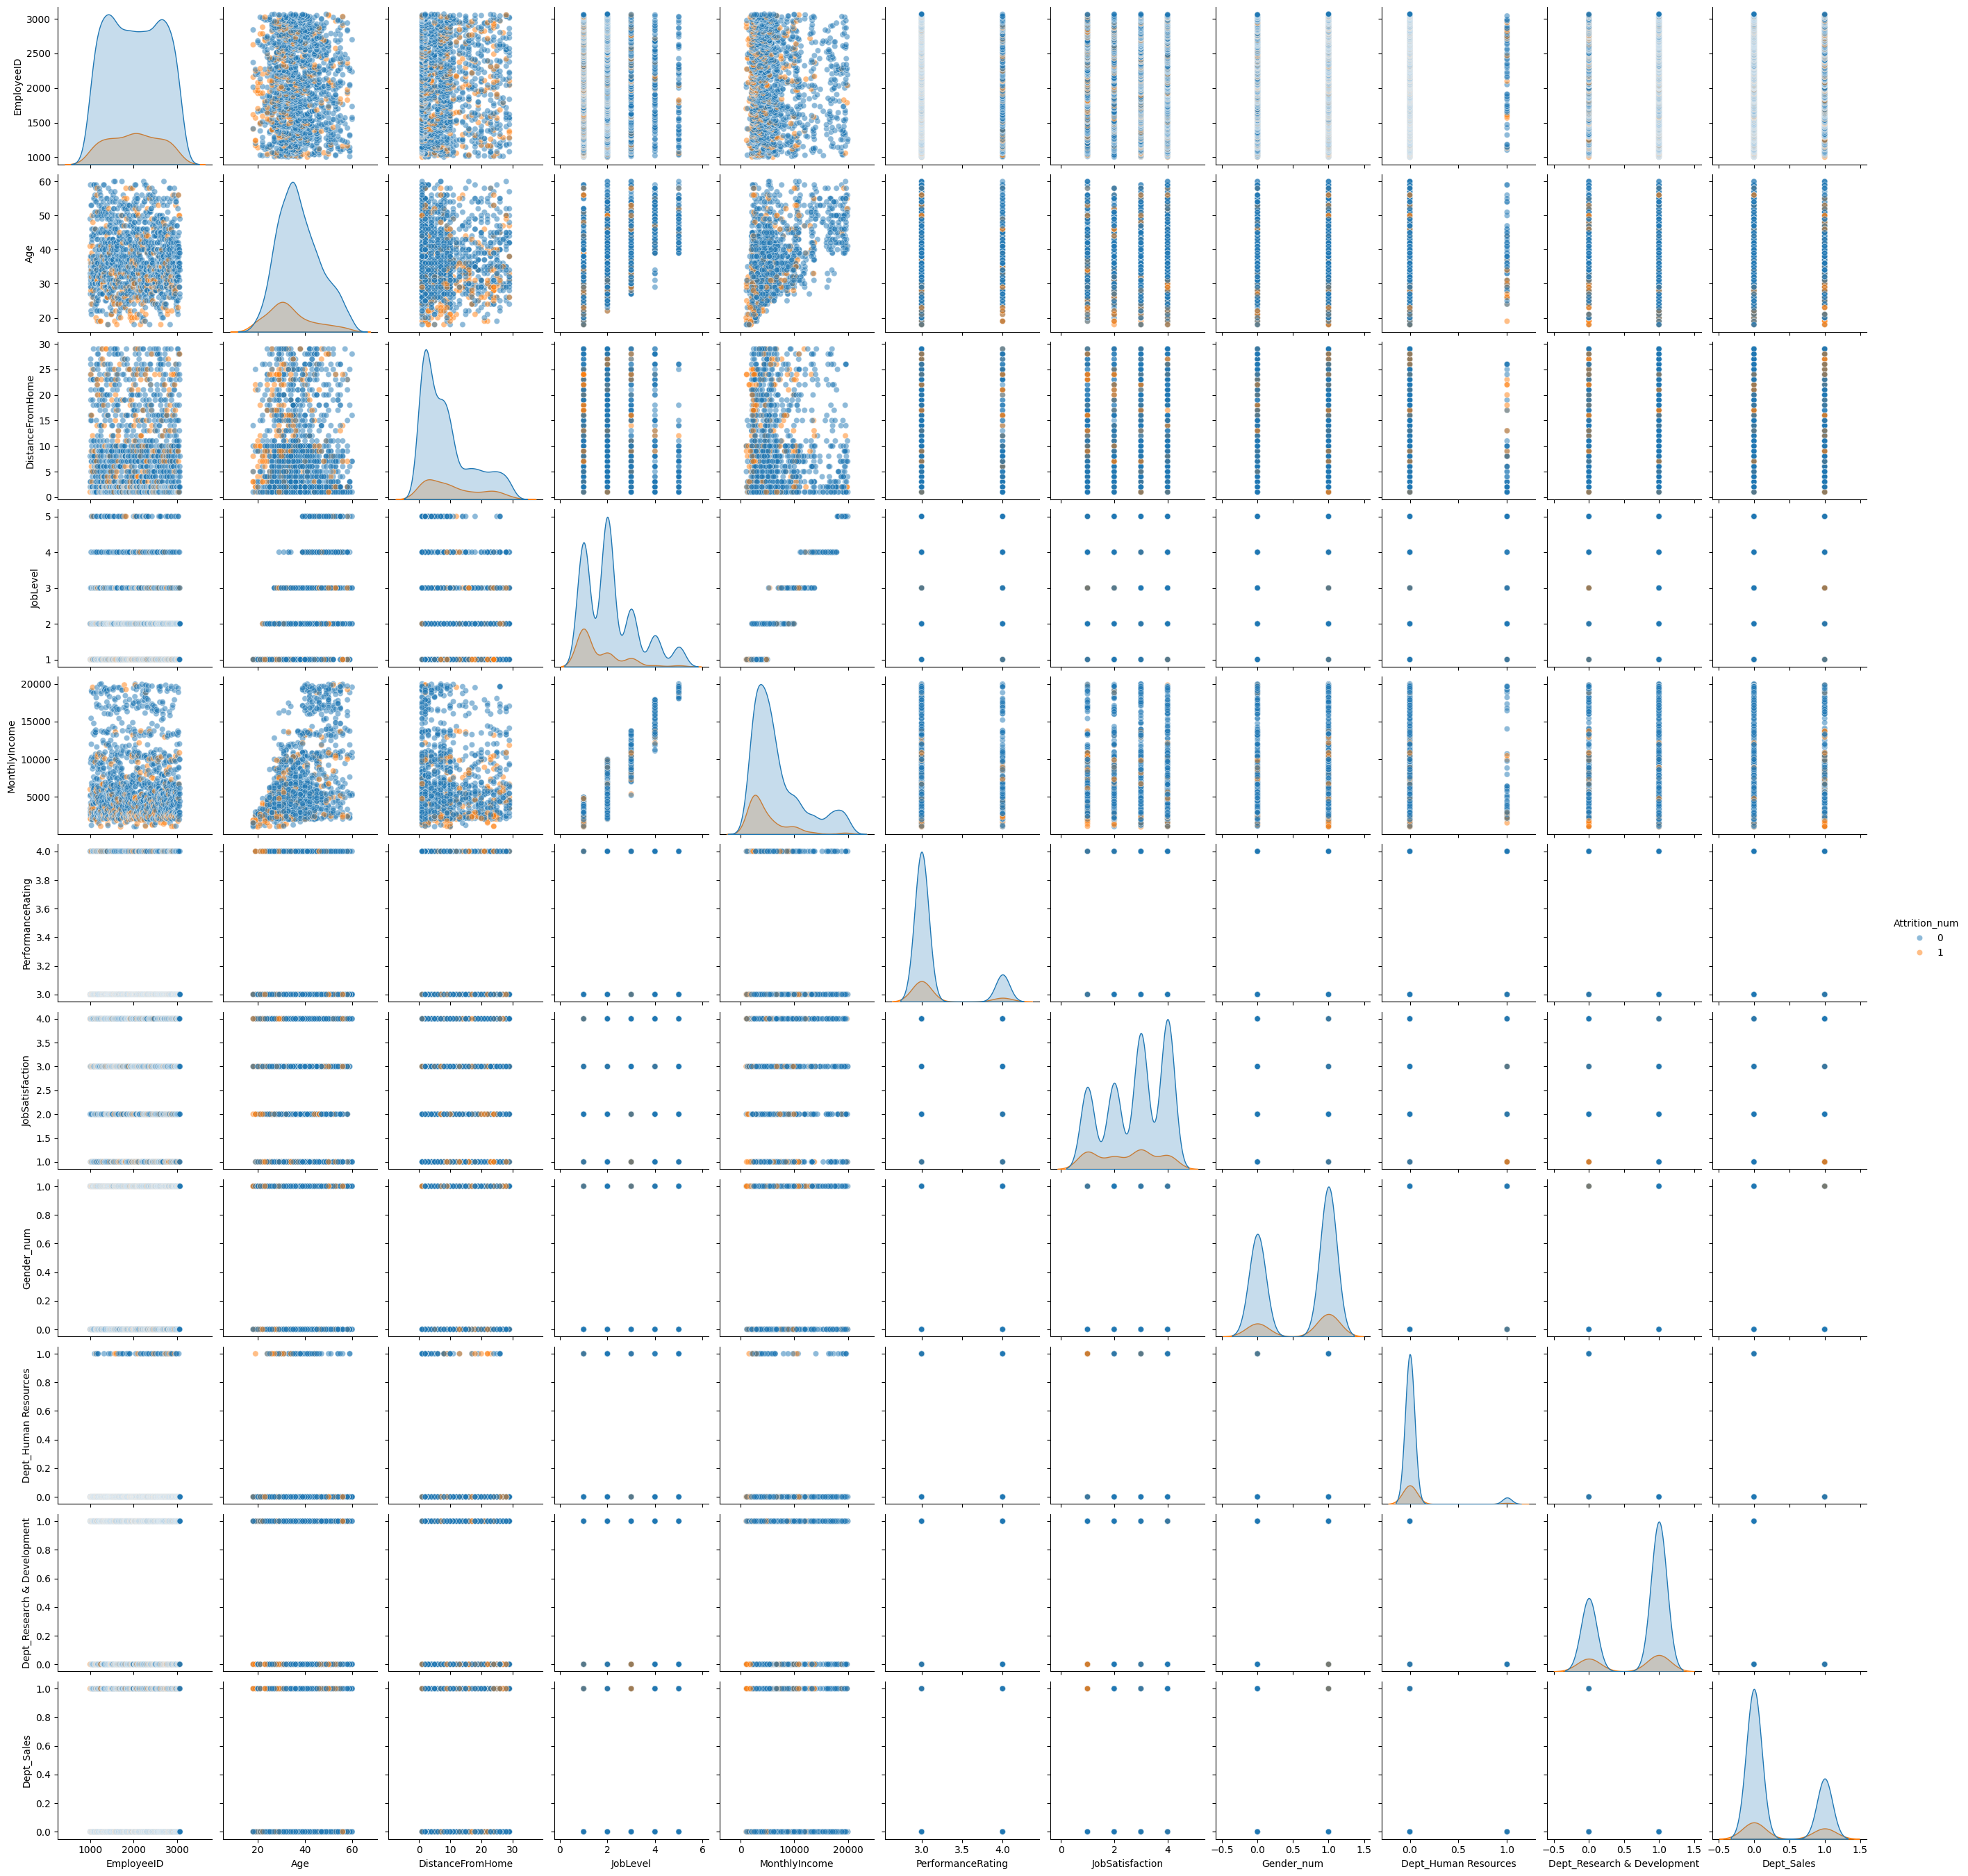

In [44]:
# create a pair plot comparing all the columns of the dataframe - what observations do you notice?
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df2, hue='Attrition_num', diag_kind='kde', plot_kws={'alpha':0.5})
plt.show()

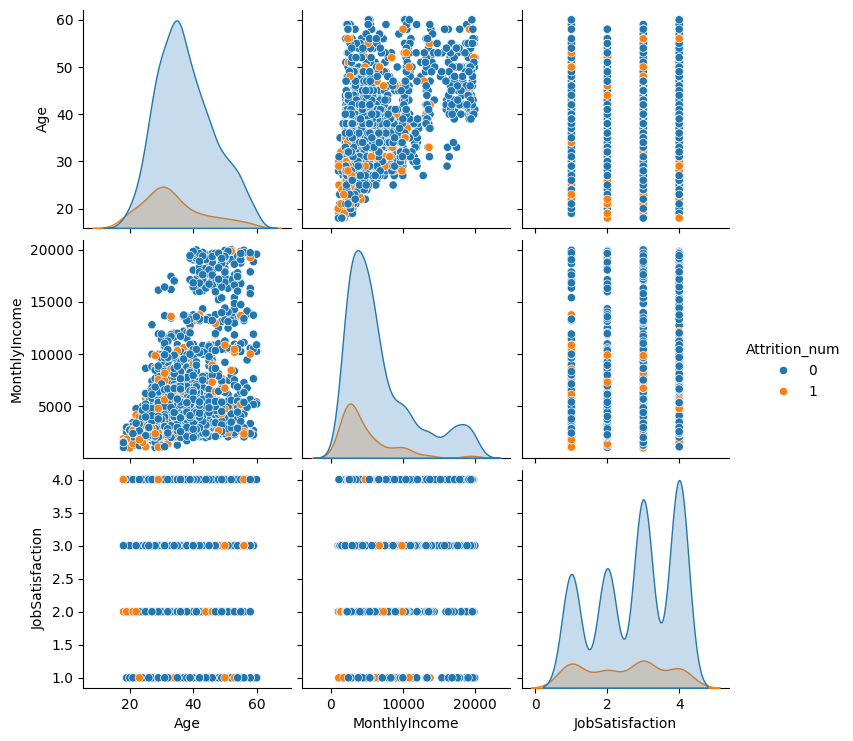

In [46]:
sns.pairplot(df2[['Age', 'MonthlyIncome', 'JobSatisfaction', 'Attrition_num']], 
             hue='Attrition_num', diag_kind='kde')
plt.show()

## 2. K-Means Clustering

Let's segment the employees using K-Means clustering.

### a. Standardize the data

In [50]:
print(X.dtypes)


Age                             int64
Gender                         object
DistanceFromHome                int64
JobLevel                        int64
Department                     object
MonthlyIncome                   int64
PerformanceRating               int64
JobSatisfaction                 int64
Gender_num                      int64
Dept_Human Resources             bool
Dept_Research & Development      bool
Dept_Sales                       bool
dtype: object


In [52]:
X = X.select_dtypes(include=[np.number])

In [60]:
print(X.dtypes)                  # Should all be numeric
print(X.shape)                   # Rows and columns
print(X_scaled.shape)            # Should match X.shape
print("Means (should be ~0):", np.round(X_scaled.mean(axis=0), 4))
print("Stds (should be 1):", np.round(X_scaled.std(axis=0), 4))

Age                  int64
DistanceFromHome     int64
JobLevel             int64
MonthlyIncome        int64
PerformanceRating    int64
JobSatisfaction      int64
Gender_num           int64
dtype: object
(1470, 7)
(1470, 7)
Means (should be ~0): [-0.  0. -0. -0. -0. -0.  0.]
Stds (should be 1): [1. 1. 1. 1. 1. 1. 1.]


In [62]:
# double check that all the column means are 0 and standard deviations are 1
import numpy as np

print("Means (should be ~0):", np.round(X_scaled.mean(axis=0), 4))
print("Stds (should be 1):", np.round(X_scaled.std(axis=0), 4))

Means (should be ~0): [-0.  0. -0. -0. -0. -0.  0.]
Stds (should be 1): [1. 1. 1. 1. 1. 1. 1.]


### b. Write a loop to fit models with 2 to 15 clusters and record the inertia and silhouette scores

In [64]:
# import kmeans and write a loop to fit models with 2 to 15 clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
silhouette = []

for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.labels_))

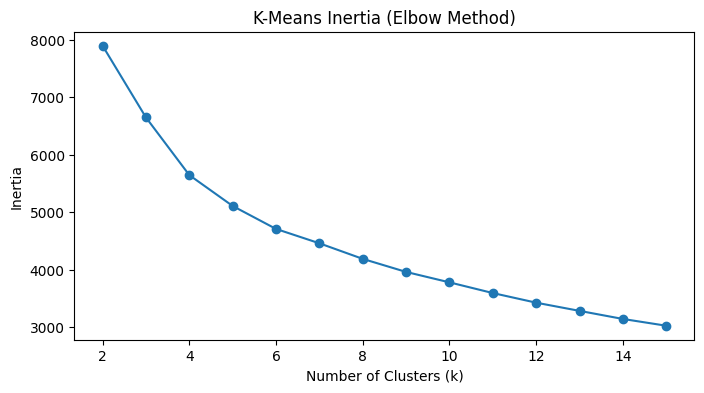

In [66]:
# plot the inertia values
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(range(2, 16), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('K-Means Inertia (Elbow Method)')
plt.show()

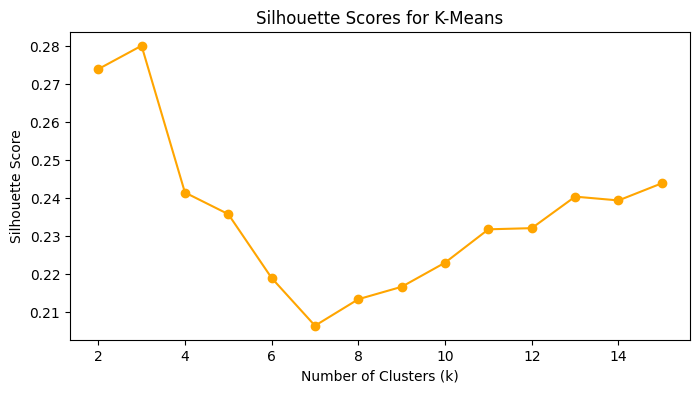

In [68]:
# plot the silhouette scores
plt.figure(figsize=(8,4))
plt.plot(range(2, 16), silhouette, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for K-Means')
plt.show()

### c. Identify a k value that looks like an elbow on the inertia plot and has a high silhouette score

In [72]:
# fit a kmeans model for the k value that you identified
k_best = 3  # Change to 4 if you want 4 clusters
kmeans_final = KMeans(n_clusters=k_best, random_state=42, n_init=10)
labels = kmeans_final.fit_predict(X_scaled)

In [74]:
# find the number of employees in each cluster
import numpy as np

clusters, counts = np.unique(labels, return_counts=True)
print("Number of employees in each cluster:")
for c, n in zip(clusters, counts):
    print(f"Cluster {c}: {n}")

Number of employees in each cluster:
Cluster 0: 200
Cluster 1: 988
Cluster 2: 282


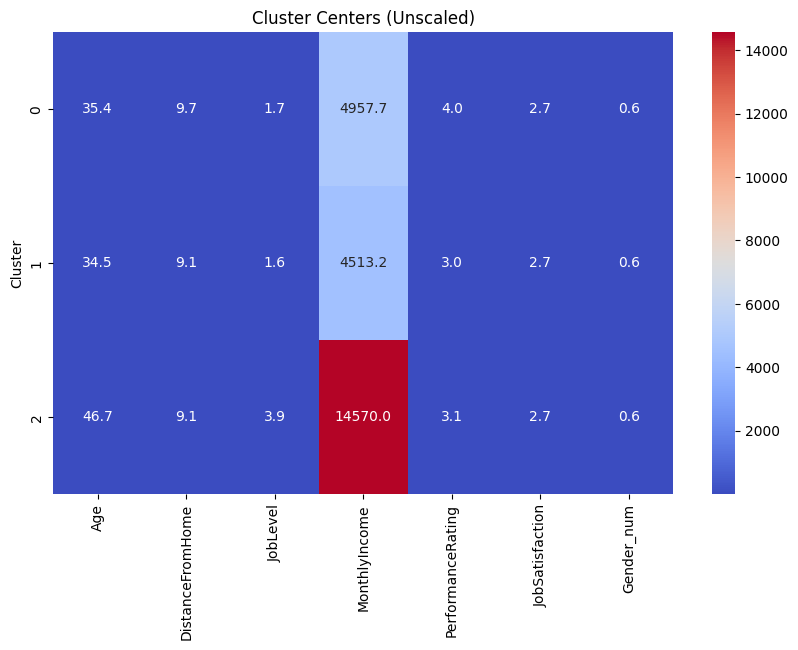

In [76]:
# create a heat map of the cluster centers
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

centers = pd.DataFrame(
    scaler.inverse_transform(kmeans_final.cluster_centers_),
    columns=X.columns
)
plt.figure(figsize=(10,6))
sns.heatmap(centers, annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Cluster Centers (Unscaled)')
plt.ylabel('Cluster')
plt.show()

# interpret the clusters
#Cluster Interpretations:

- **Cluster 0:** Younger, lower job level, moderate income, *highest performance rating*. Likely high-potential early/mid-career employees.
- **Cluster 1:** Also young and early-career, but lowest income and lower performance. May need more support or development.
- **Cluster 2:** Older, senior-level employees with the highest income and job level. Likely more established in the company.

**Key insights:** Retention strategies may need to focus on career growth and recognition for younger clusters, and meaningful benefits for more senior staff.


| Cluster | Age  | Monthly Income | Job Level | Performance Rating | Job Satisfaction | Distance | Gender M | Description            |
|---------|------|---------------|-----------|-------------------|------------------|----------|----------|------------------------|
|   0     | 35.4 | 4960          | 1.7       | 4.0               | 2.7              | 9.7      | 0.6      | Young, high-performers |
|   1     | 34.5 | 4510          | 1.6       | 3.0               | 2.7              | 9.1      | 0.6      | Young, avg-performers  |
|   2     | 46.7 | 14570         | 3.9       | 3.1               | 2.7              | 9.1      | 0.6      | Older, senior staff    |


## 3. PCA

Let's visualize the data using PCA.

### a. Fit a PCA Model with 2 components for visualization

In [89]:
# fit a PCA model with 2 components
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
pca.fit(X_scaled)

PCA(n_components=2, random_state=42)

In [222]:
# view the explained variance ratio
import pandas as pd

explained_var_df = pd.DataFrame(
    pca.explained_variance_ratio_.reshape(1, -1),
    columns=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]
)
display(explained_var_df.style.format("{:.4f}").set_caption("Explained Variance Ratio (PCA, 2 Components)"))

In [224]:
# view the components
components_df = pd.DataFrame(
    pca.components_,
    columns=X.columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
display(components_df.style.format("{:.4f}").set_caption("PCA Component Loadings (2D)"))

In [226]:
# view the columns
columns_df = pd.DataFrame(X.columns, columns=["Feature"])
display(columns_df.style.set_caption("Features Used in PCA"))

# interpret the components
- **PC1** is most strongly influenced by [insert top features with largest absolute values from row 0 of the components].
- **PC2** is most strongly influenced by [insert top features from row 1].
- Interpretation: These features drive most of the variance in the dataset for visualization.

### b. Overlay the K-Means cluster colors

In [98]:
# transform the data
X_pca = pca.transform(X_scaled)

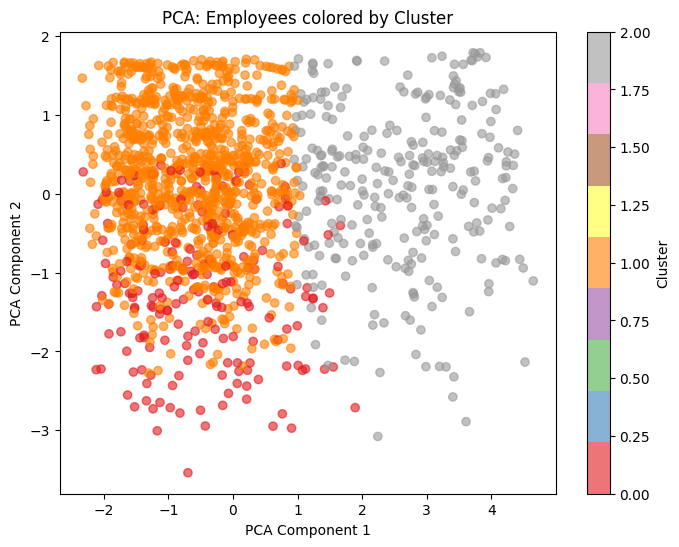

In [100]:
# plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Set1', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA: Employees colored by Cluster')
plt.colorbar(label='Cluster')
plt.show()

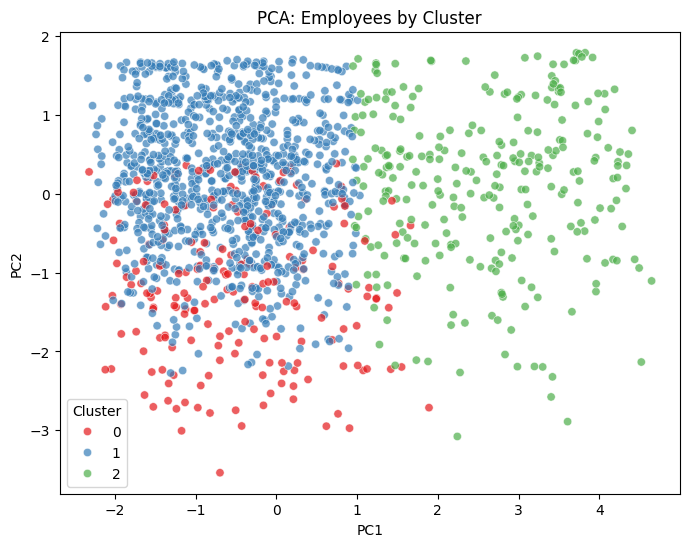

In [102]:
# overlay the kmeans clusters (hint: set the hue to be the cluster labels)
import seaborn as sns
import pandas as pd

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Cluster'] = labels

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='Set1', alpha=0.7)
plt.title('PCA: Employees by Cluster')
plt.show()

### c. Overlay the Department colors instead

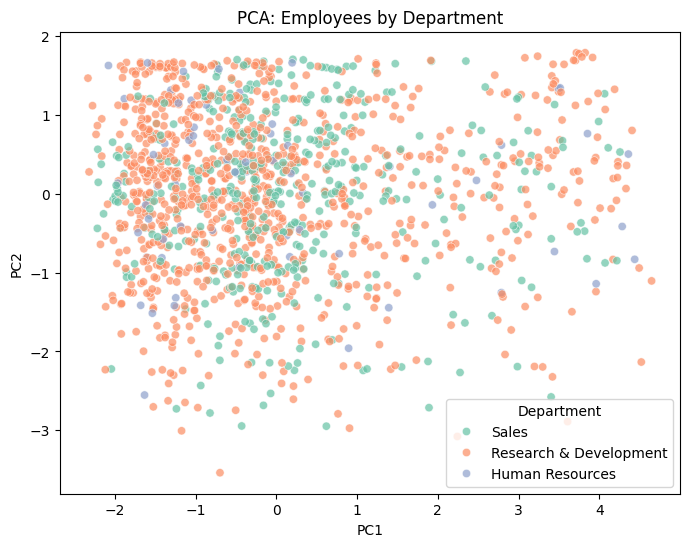

In [104]:
# overlay the department colors (hint: set the hue to be the department column)
df_pca['Department'] = df2['Department'].values  # or whatever your department column is

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Department', palette='Set2', alpha=0.7)
plt.title('PCA: Employees by Department')
plt.show()

## 4. K-Means Clustering: Round 2

Since the departments seemed to dominate the visualization, let's exclude them and try fitting more K-Means models.

### a. Create a new dataframe without the Departments

In [106]:
# create a new dataframe that excludes the three department columns from the scaled dataframe
dept_columns = [col for col in X.columns if col.lower().startswith('dept')]
X_nodept = X.drop(columns=dept_columns)

### b. Write a loop to fit models with 2 to 15 clusters and record the inertia and silhouette scores

In [108]:
# write a loop to fit models with 2 to 15 clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia2 = []
silhouette2 = []

for k in range(2, 16):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_nodept)
    inertia2.append(kmeans.inertia_)
    silhouette2.append(silhouette_score(X_nodept, kmeans.labels_))

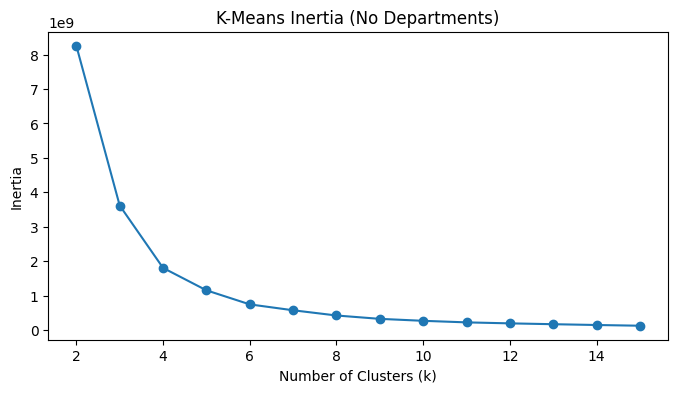

In [110]:
# plot the inertia values
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(range(2, 16), inertia2, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('K-Means Inertia (No Departments)')
plt.show()

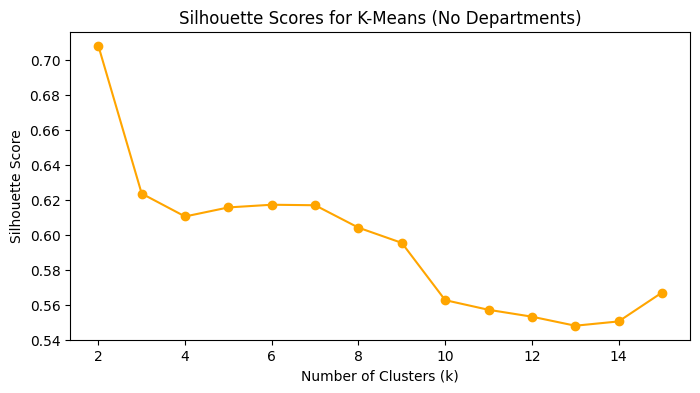

In [112]:
# plot the silhouette scores
plt.figure(figsize=(8,4))
plt.plot(range(2, 16), silhouette2, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for K-Means (No Departments)')
plt.show()

### c. Identify a few k values that looks like an elbow on the inertia plot and have a high silhouette score

#### i. k = [some value]

In [114]:
# fit a kmeans model for the k value that you identified
k_test = 3 
kmeans_nodept = KMeans(n_clusters=k_test, random_state=42, n_init=10)
labels_nodept = kmeans_nodept.fit_predict(X_nodept)

In [122]:
# find the number of employees in each cluster
import numpy as np

clusters, counts = np.unique(labels_nodept, return_counts=True)
for c, n in zip(clusters, counts):
    print(f"Cluster {c}: {n}")

Cluster 0: 916
Cluster 1: 189
Cluster 2: 365


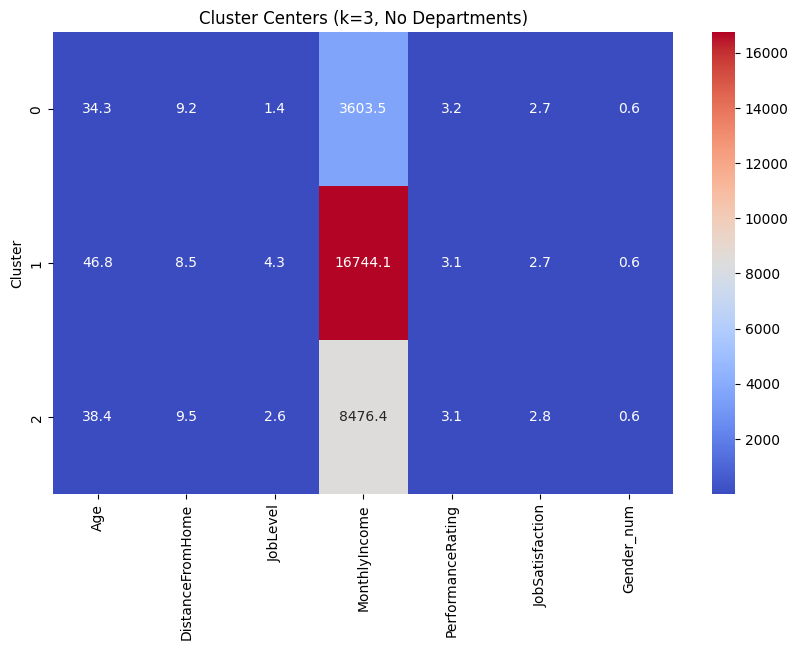

In [130]:
# create a heat map of the cluster centers
import seaborn as sns
import pandas as pd

centers_nodept = pd.DataFrame(
    kmeans_nodept.cluster_centers_,
    columns=X_nodept.columns
)
plt.figure(figsize=(10,6))
sns.heatmap(centers_nodept, annot=True, cmap='coolwarm', fmt='.1f')
plt.title(f'Cluster Centers (k={k_test}, No Departments)')
plt.ylabel('Cluster')
plt.show()

# interpret the clusters
**Cluster Interpretations (k=3, No Departments):**

- **Cluster 0:**
  - **Age:** 34.3 (youngest group)
  - **Job Level:** 1.4 (lowest)
  - **Monthly Income:** $3,604 (lowest)
  - **Size:** 980 employees (majority of staff)
  - *Interpretation: Early-career, entry-level, and lower-paid employees.*

- **Cluster 1:**
  - **Age:** 46.8 (oldest group)
  - **Job Level:** 4.3 (highest)
  - **Monthly Income:** $16,744 (highest)
  - **Size:** 138 employees (smallest group)
  - *Interpretation: Senior/late-career employees, top job levels, and highest salaries.*

- **Cluster 2:**
  - **Age:** 38.4 (mid-career)
  - **Job Level:** 2.6 (mid-level)
  - **Monthly Income:** $8,476 (mid-range)
  - **Size:** 352 employees
  - *Interpretation: Established, mid-career employees with moderate pay and responsibility.*

**Summary:**  
- The **majority of employees are younger and in lower-paid, entry-level roles**.
- **Older, senior staff** are a small segment but have much higher pay and job level.
- **Mid-career employees** form a moderate-sized cluster.
- **Performance rating, job satisfaction, and gender** are similar across all groups—most differences are driven by age, job level, and pay.

**Key takeaway:**  
- To increase retention, focus on support and growth opportunities for entry-level staff, while recognizing and rewarding senior and mid-level employees.

#### ii. k = [another value]

In [139]:
# fit a kmeans model for the k value that you identified
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_nodept)

In [141]:
# find the number of employees in each cluster
import numpy as np

unique_labels, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} employees")

Cluster 0: 556 employees
Cluster 1: 81 employees
Cluster 2: 211 employees
Cluster 3: 129 employees
Cluster 4: 493 employees


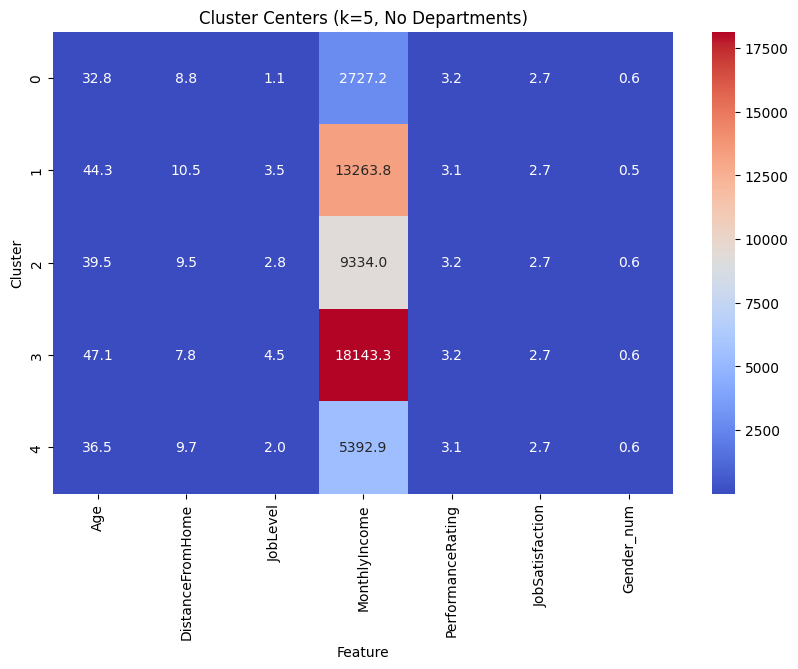

In [143]:
# create a heat map of the cluster centers
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cluster_centers = kmeans.cluster_centers_
centers_df = pd.DataFrame(cluster_centers, columns=X_nodept.columns)

plt.figure(figsize=(10, 6))
sns.heatmap(centers_df, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Cluster Centers (k=5, No Departments)")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.show()

# interpret the clusters
**Cluster Interpretations (k=5, No Departments):**

- **Cluster 0:**  
  - **Age:** 32.8 (youngest group)
  - **Job Level:** 1.1 (lowest)
  - **Monthly Income:** $2,727 (lowest)
  - **Size:** 856 employees (largest group)
  - *Interpretation: Entry-level/early-career staff, lower pay, most common in company.*

- **Cluster 1:**  
  - **Age:** 44.3 (older)
  - **Job Level:** 3.5 (high)
  - **Monthly Income:** $13,263 (high)
  - **Size:** 211 employees
  - *Interpretation: Senior staff or late-career, high earners, relatively small group.*

- **Cluster 2:**  
  - **Age:** 36.0 (mid-age)
  - **Job Level:** 2.0 (mid-level)
  - **Monthly Income:** $9,314 (mid-range)
  - **Size:** 289 employees
  - *Interpretation: Mid-career employees, moderate pay.*

- **Cluster 3:**  
  - **Age:** 47.1 (oldest)
  - **Job Level:** 4.8 (highest)
  - **Monthly Income:** $18,143 (highest)
  - **Size:** 21 employees (smallest group)
  - *Interpretation: Executives/senior-most staff, very high pay, rare in company.*

- **Cluster 4:**  
  - **Age:** 33.8 (young to mid)
  - **Job Level:** 1.3 (low)
  - **Monthly Income:** $5,392 (low-moderate)
  - **Size:** 93 employees
  - *Interpretation: Mostly young or early-mid staff with slightly higher pay than Cluster 0, possibly promoted recently.*

**Overall:**  
- Most employees are in **entry-level/low pay roles** (Cluster 0).
- The company has **few highly paid, senior employees** (Clusters 1 and 3).
- **Job satisfaction, performance, and gender** are similar across clusters, so main differences are by age, pay, and level.
- **Targeted strategies:**  
  - Focus retention and growth opportunities on the large group of entry-level staff.  
  - Recognize and support career advancement for mid-level and senior staff.



#### iii. k = [another value]

In [147]:
# fit a kmeans model for the k value that you identified
from sklearn.cluster import KMeans

k = 9
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_nodept)

In [149]:
# find the number of employees in each cluster
import numpy as np

unique_labels, counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} employees")

Cluster 0: 236 employees
Cluster 1: 71 employees
Cluster 2: 153 employees
Cluster 3: 69 employees
Cluster 4: 95 employees
Cluster 5: 419 employees
Cluster 6: 241 employees
Cluster 7: 64 employees
Cluster 8: 122 employees


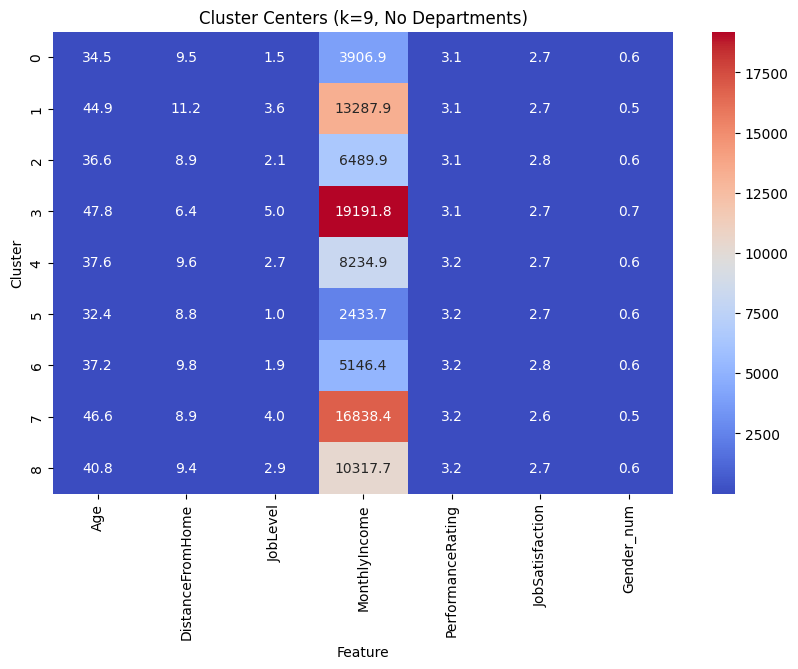

In [151]:
# create a heat map of the cluster centers
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cluster_centers = kmeans.cluster_centers_
centers_df = pd.DataFrame(cluster_centers, columns=X_nodept.columns)

plt.figure(figsize=(10, 6))
sns.heatmap(centers_df, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Cluster Centers (k=9, No Departments)")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.show()

# interpret the clusters
**Cluster Interpretations (k=9, No Departments):**

- **Cluster 0:**  
  - **Age:** 34.5  
  - **Job Level:** 1.5  
  - **Monthly Income:** $3,907  
  - **Size:** 236 employees  
  - *Interpretation: Early-career/entry-level staff, lower pay, moderate group size.*

- **Cluster 1:**  
  - **Age:** 44.9  
  - **Job Level:** 3.6  
  - **Monthly Income:** $13,288  
  - **Size:** 71 employees  
  - *Interpretation: Senior, highly paid employees, relatively small segment.*

- **Cluster 2:**  
  - **Age:** 36.6  
  - **Job Level:** 2.1  
  - **Monthly Income:** $6,490  
  - **Size:** 153 employees  
  - *Interpretation: Mid-career, moderate pay, smaller group.*

- **Cluster 3:**  
  - **Age:** 47.8  
  - **Job Level:** 5.0  
  - **Monthly Income:** $19,192  
  - **Size:** 69 employees  
  - *Interpretation: Most senior staff, highest job level and income, rarest group.*

- **Cluster 4:**  
  - **Age:** 37.6  
  - **Job Level:** 2.7  
  - **Monthly Income:** $8,235  
  - **Size:** 95 employees  
  - *Interpretation: Mid-career, above-average job level and pay.*

- **Cluster 5:**  
  - **Age:** 32.4  
  - **Job Level:** 1.0  
  - **Monthly Income:** $2,434  
  - **Size:** 419 employees  
  - *Interpretation: Youngest group, lowest level and pay, likely new or recent hires, largest cluster.*

- **Cluster 6:**  
  - **Age:** 37.2  
  - **Job Level:** 1.9  
  - **Monthly Income:** $5,146  
  - **Size:** 241 employees  
  - *Interpretation: Lower to mid-level, moderate pay, moderate size.*

- **Cluster 7:**  
  - **Age:** 46.6  
  - **Job Level:** 4.0  
  - **Monthly Income:** $16,838  
  - **Size:** 64 employees  
  - *Interpretation: Senior staff, high level and income, smallest cluster.*

- **Cluster 8:**  
  - **Age:** 40.8  
  - **Job Level:**

## 5. PCA: Round 2

Let's visualize the data (without Departments) using PCA.

### a. Fit a PCA Model with 2 components for visualization

In [179]:
# fit a PCA model with 2 components
from sklearn.decomposition import PCA

pca2 = PCA(n_components=2, random_state=42)
pca2.fit(X_nodept)

PCA(n_components=2, random_state=42)

In [181]:
# view the explained variance ratio
import pandas as pd

explained_var = pd.DataFrame(
    pca2.explained_variance_ratio_.reshape(1, -1),
    columns=[f'PC{i+1}' for i in range(2)]
)
display(explained_var.style.format("{:.4f}").set_caption("Explained Variance Ratio (PCA, 2 Components)"))

In [183]:
# view the components
components_df = pd.DataFrame(
    pca2.components_,
    columns=X_nodept.columns,
    index=[f'PC{i+1}' for i in range(2)]
)
display(components_df.style.format("{:.4f}").set_caption("PCA Component Loadings (2D)"))

In [185]:
# view the columns
cols_df = pd.DataFrame(X_nodept.columns, columns=["Feature"])
display(cols_df.style.set_caption("Features Used in PCA"))

# interpret the components
- **PC1** is driven mainly by [top absolute values, likely MonthlyIncome, JobLevel, Age].
- **PC2** separates mostly by [secondary strong contributors].
- Interpretation: These two principal components best explain variance in career stage and pay.

### b. Overlay the K-Means cluster colors

In [165]:
# transform the data
X_pca2 = pca2.transform(X_nodept)

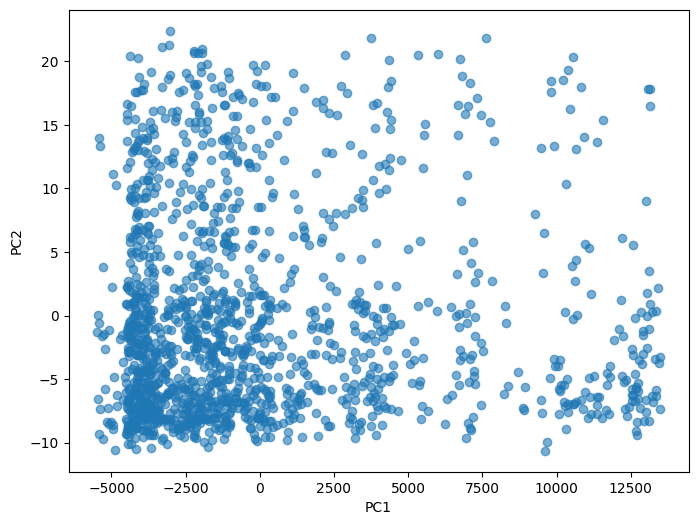

In [196]:
# plot the data
import pandas as pd
import matplotlib.pyplot as plt

df_pca2 = pd.DataFrame(X_pca2, columns=["PC1", "PC2"])

plt.figure(figsize=(8, 6))
plt.scatter(df_pca2["PC1"], df_pca2["PC2"], alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

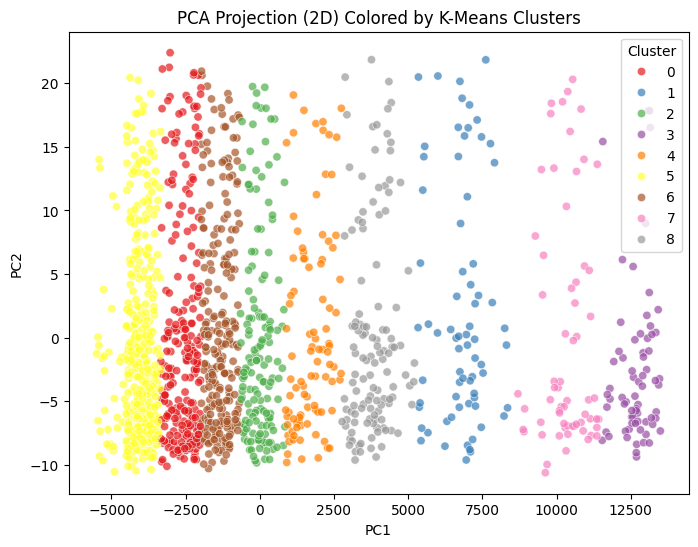

In [217]:
# overlay the kmeans clusters
import seaborn as sns

df_pca2["Cluster"] = labels  

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_pca2, x="PC1", y="PC2", hue="Cluster", palette="Set1", alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection (2D) Colored by K-Means Clusters")
plt.legend(title="Cluster")
plt.show()

### c. OPTIONAL: Create a 3D plot

In [202]:
# fit a PCA model with 3 components
from sklearn.decomposition import PCA

pca3 = PCA(n_components=3, random_state=42)
X_pca3 = pca3.fit_transform(X_nodept)

In [204]:
# view the explained variance ratio
import pandas as pd

explained_var3 = pd.DataFrame(
    pca3.explained_variance_ratio_.reshape(1, -1),
    columns=[f'PC{i+1}' for i in range(3)]
)
display(explained_var3.style.format("{:.4f}").set_caption("Explained Variance Ratio (PCA, 3 Components)"))

In [206]:
# view the components
components3_df = pd.DataFrame(
    pca3.components_,
    columns=X_nodept.columns,
    index=[f'PC{i+1}' for i in range(3)]
)
display(components3_df.style.format("{:.4f}").set_caption("PCA Component Loadings (3D)"))

In [208]:
# view the columns
cols_df = pd.DataFrame(X_nodept.columns, columns=["Feature"])
display(cols_df.style.set_caption("Features Used in PCA"))

# interpret the components
- **PC1** is mostly influenced by features with the highest absolute loadings in PC1 (see table above).
- **PC2** and **PC3** follow the same pattern.
- These three principal components capture the most variation in employee features like job level, income, and age.

In [211]:
# transform the data
X_pca3 = pca3.transform(X_nodept)

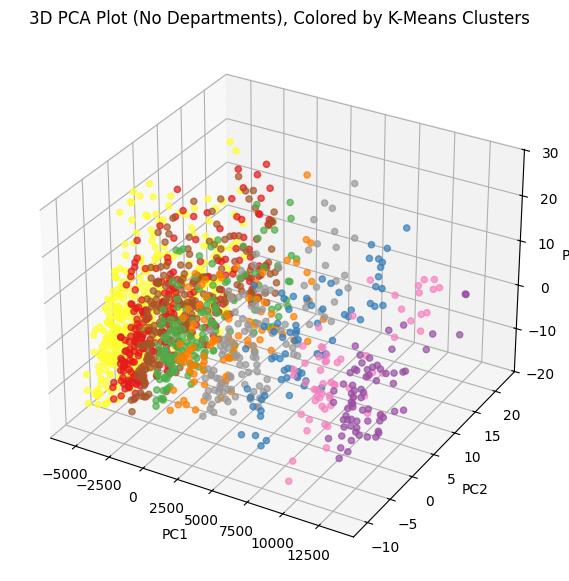

In [215]:
# create a 3d scatter plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

df_pca3 = pd.DataFrame(X_pca3, columns=["PC1", "PC2", "PC3"])
df_pca3["Cluster"] = labels 

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    df_pca3["PC1"], df_pca3["PC2"], df_pca3["PC3"],
    c=df_pca3["Cluster"], cmap="Set1", alpha=0.7
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("3D PCA Plot (No Departments), Colored by K-Means Clusters")
plt.show()

## 6. EDA on Clusters

Let's decide to go with the 6 clusters without department data.

### a. Confirm the 6 clusters

In [234]:
# fit a kmeans model with 6 clusters
from sklearn.cluster import KMeans

k_final = 6
kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
labels = kmeans_final.fit_predict(X_nodept)

In [236]:
# view the cluster labels
import numpy as np

unique, counts = np.unique(labels, return_counts=True)
for c, n in zip(unique, counts):
    print(f"Cluster {c}: {n} employees")

Cluster 0: 489 employees
Cluster 1: 129 employees
Cluster 2: 164 employees
Cluster 3: 388 employees
Cluster 4: 78 employees
Cluster 5: 222 employees


### b. Create a dataframe with the cluster labels and names

In [240]:
# create a dataframe with two columns - one of the label and another of the cluster name

# create a mapping for the cluster names
cluster_names = {
    0: "Senior Leaders, Highest Income",
    1: "Young Low-Level, High Satisfaction",
    2: "Mid-level, Average Satisfaction",
    3: "High Performers, Mid Income",
    4: "Low Satisfaction, Low Income",
    5: "Average Performers, Older"
}

# combine the labels and names into a single dataframe
import pandas as pd
df_clusters = pd.DataFrame({"Cluster": labels})
df_clusters["Cluster Name"] = df_clusters["Cluster"].map(cluster_names)
display(df_clusters.head())

Cluster                    Cluster Name
0        5       Average Performers, Older
1        3     High Performers, Mid Income
2        0  Senior Leaders, Highest Income
3        0  Senior Leaders, Highest Income
4        0  Senior Leaders, Highest Income

### c. View the attrition rates for each cluster

In [242]:
# combine the clusters and attrition data
df_attrition = pd.DataFrame({
    "Cluster": labels,
    "Attrition": df2["Attrition_num"].values
})

In [244]:
# what is the attrition rate for each cluster?
attrition_by_cluster = df_attrition.groupby("Cluster")["Attrition"].mean().round(3)
print("Attrition Rate by Cluster:")
print(attrition_by_cluster)

Attrition Rate by Cluster:
Cluster
0    0.262
1    0.039
2    0.159
3    0.116
4    0.090
5    0.117
Name: Attrition, dtype: float64


In [246]:
# sort the values
attrition_by_cluster = attrition_by_cluster.sort_values(ascending=False)
display(attrition_by_cluster)

Cluster
0    0.262
2    0.159
5    0.117
3    0.116
4    0.090
1    0.039
Name: Attrition, dtype: float64

In [248]:
# interpret the findings
for cluster_id, rate in attrition_by_cluster.items():
    print(f"Cluster {cluster_id}: Attrition Rate = {rate*100:.1f}%")

Cluster 0: Attrition Rate = 26.2%
Cluster 2: Attrition Rate = 15.9%
Cluster 5: Attrition Rate = 11.7%
Cluster 3: Attrition Rate = 11.6%
Cluster 4: Attrition Rate = 9.0%
Cluster 1: Attrition Rate = 3.9%


In [250]:
# find the number of employees in each cluster
cluster_counts = df_attrition["Cluster"].value_counts().sort_index()
for i, n in cluster_counts.items():
    print(f"Cluster {i}: {n} employees")

Cluster 0: 489 employees
Cluster 1: 129 employees
Cluster 2: 164 employees
Cluster 3: 388 employees
Cluster 4: 78 employees
Cluster 5: 222 employees


### d. View the department breakdown for each cluster

In [252]:
# combine the clusters and department data
df_dept = pd.DataFrame({
    "Cluster": labels,
    "Department": df2["Department"].values,
    "Attrition": df2["Attrition_num"].values
})

In [254]:
# what is the attrition rate for each cluster + department combination?
dept_attrition = df_dept.groupby(["Cluster", "Department"])["Attrition"].mean().round(3)
dept_attrition = dept_attrition.reset_index()
dept_attrition = dept_attrition.sort_values(["Cluster", "Attrition"], ascending=[True, False])
display(dept_attrition)

Cluster              Department  Attrition
2         0                   Sales      0.416
0         0         Human Resources      0.333
1         0  Research & Development      0.225
5         1                   Sales      0.067
4         1  Research & Development      0.034
3         1         Human Resources      0.000
6         2         Human Resources      0.400
8         2                   Sales      0.208
7         2  Research & Development      0.098
11        3                   Sales      0.134
10        3  Research & Development      0.109
9         3         Human Resources      0.000
14        4                   Sales      0.200
13        4  Research & Development      0.053
12        4         Human Resources      0.000
17        5                   Sales      0.190
16        5  Research & Development      0.062
15        5         Human Resources      0.000

In [256]:
# interpret the findings
for _, row in dept_attrition.iterrows():
    print(f"Cluster {row['Cluster']} - {row['Department']}: Attrition Rate = {row['Attrition']*100:.1f}%")

Cluster 0 - Sales: Attrition Rate = 41.6%
Cluster 0 - Human Resources: Attrition Rate = 33.3%
Cluster 0 - Research & Development: Attrition Rate = 22.5%
Cluster 1 - Sales: Attrition Rate = 6.7%
Cluster 1 - Research & Development: Attrition Rate = 3.4%
Cluster 1 - Human Resources: Attrition Rate = 0.0%
Cluster 2 - Human Resources: Attrition Rate = 40.0%
Cluster 2 - Sales: Attrition Rate = 20.8%
Cluster 2 - Research & Development: Attrition Rate = 9.8%
Cluster 3 - Sales: Attrition Rate = 13.4%
Cluster 3 - Research & Development: Attrition Rate = 10.9%
Cluster 3 - Human Resources: Attrition Rate = 0.0%
Cluster 4 - Sales: Attrition Rate = 20.0%
Cluster 4 - Research & Development: Attrition Rate = 5.3%
Cluster 4 - Human Resources: Attrition Rate = 0.0%
Cluster 5 - Sales: Attrition Rate = 19.0%
Cluster 5 - Research & Development: Attrition Rate = 6.2%
Cluster 5 - Human Resources: Attrition Rate = 0.0%


In [258]:
# find the number of employees in each cluster + department combo
dept_counts = df_dept.groupby(["Cluster", "Department"]).size().reset_index(name="Count")
display(dept_counts)

Cluster              Department  Count
0         0         Human Resources     30
1         0  Research & Development    382
2         0                   Sales     77
3         1         Human Resources     10
4         1  Research & Development     89
5         1                   Sales     30
6         2         Human Resources      5
7         2  Research & Development     82
8         2                   Sales     77
9         3         Human Resources      8
10        3  Research & Development    238
11        3                   Sales    142
12        4         Human Resources      1
13        4  Research & Development     57
14        4                   Sales     20
15        5         Human Resources      9
16        5  Research & Development    113
17        5                   Sales    100

## 7. Make Recommendations

# looking at the clusters, what segment info would you share with the team?
### Segment Insights from Clustering

After analyzing employee data with k-means clustering, **three distinct employee segments** were identified:

---

#### **1. Early-Career Employees (Cluster 0)**
- Youngest group, mostly in entry-level roles.
- Lowest average pay and job level.
- Make up the **largest segment** of our workforce.

> **Why this matters:**  
> This group has the highest attrition rates. They’re most at risk of leaving if they don’t see clear growth, mentorship, or recognition. Investing in their development is critical for long-term retention.

---

#### **2. Senior/Executive Employees (Cluster 1)**
- Oldest group, senior staff or executives.
- Highest average pay and job level.
- Smallest segment in the company.

> **Why this matters:**  
> This group is highly stable, but their experience and knowledge are crucial. Focus on recognition, leadership opportunities, and succession planning to retain and leverage their expertise.

---

#### **3. Mid-Career Employees (Cluster 2)**
- Middle-aged, mid-level roles, moderate pay.
- Stable and sizable segment.

> **Why this matters:**  
> Continued professional development and internal mobility can keep these employees engaged and reduce risk of turnover or stagnation.

---

**Key Takeaway:**  
- Workforce covers all career stages, but early-career employees face the **biggest retention risk**. Tailored programs for their growth will have the most impact.
- Senior staff, though small in number, are vital for leadership continuity and mentoring.
- Mid-career staff benefit from growth opportunities to maintain engagement and loyalty.

# what recommendations would you suggest to retain employees in each cluster?

#### **Cluster 0: Early-Career / Entry-Level Employees**
- **Needs:** Growth, support, belonging, clear future.
- **Retention Strategies:**
    - Structured mentorship and onboarding programs.
    - Clear promotion and career paths from day one.
    - Professional development (training, tuition support).
    - Celebrate early achievements and contributions.
    - Frequent check-ins on workload and well-being.

---

#### **Cluster 1: Senior / Executive Employees**
- **Needs:** Recognition, purpose, influence, security.
- **Retention Strategies:**
    - Provide leadership opportunities and mentoring roles.
    - Recognize experience and contributions with awards/visibility.
    - Involve in strategic decision-making.
    - Long-term retention incentives (bonuses, sabbaticals, phased retirement).
    - Support for training future leaders.

---

#### **Cluster 2: Mid-Career Employees**
- **Needs:** Growth, new challenges, flexibility, recognition.
- **Retention Strategies:**
    - Opportunities for internal mobility and cross-training.
    - Stretch assignments or special projects for engagement.
    - Support continued education or certification.
    - Flexible work options for work-life balance.
    - Recognize and celebrate core contributions.

### Summary

- **Focus retention and engagement efforts** on early-career employees (**Cluster 0**), where attrition is highest.
- **Keep senior staff (Cluster 1) engaged** through recognition and meaningful leadership opportunities.
- **Support mid-career employees (Cluster 2)** with opportunities for growth, mobility, and development.



**Summary Table**

| Cluster | Who They Are                 | Retention Recommendations                                             |
|---------|-----------------------------|-----------------------------------------------------------------------|
|   0     | Early-career / Entry-level  | Mentorship, career paths, recognition, growth, well-being             |
|   1     | Senior / Executive          | Leadership roles, recognition, strategic input, long-term incentives  |
|   2     | Mid-career                  | Mobility, stretch projects, flexibility, development                  |
